In [151]:
%pip install tensorflow
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install pydot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [152]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [153]:
image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


In [154]:
class_names = train_ds.class_names
print(class_names)

['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


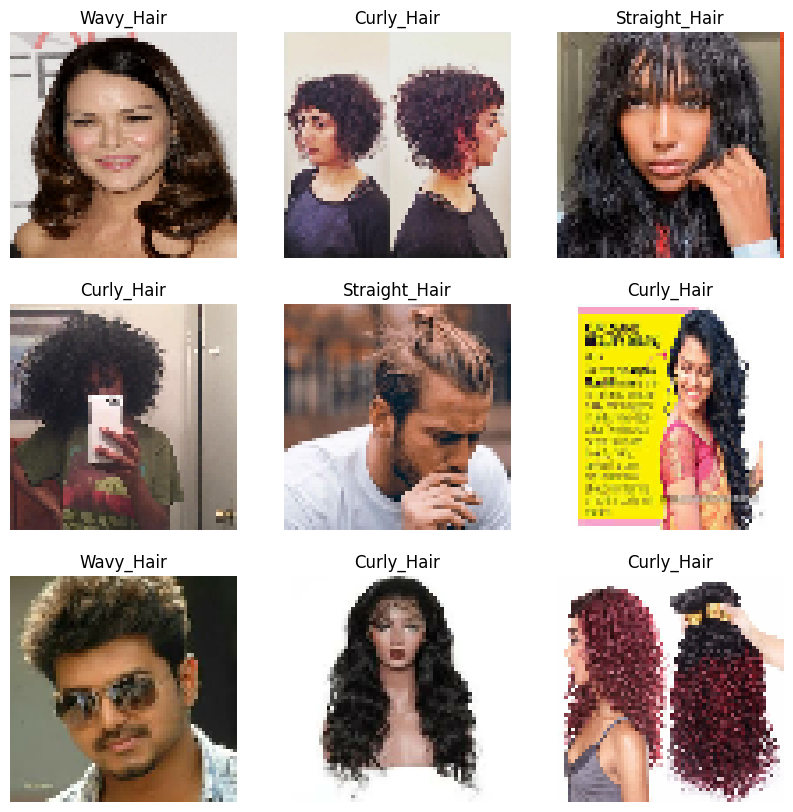

In [155]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.argmax(labels[i]))])
        plt.axis("off")
plt.show()

In [156]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [157]:
normalization_layer = layers.Rescaling(1./255)

In [158]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0002618528 1.0


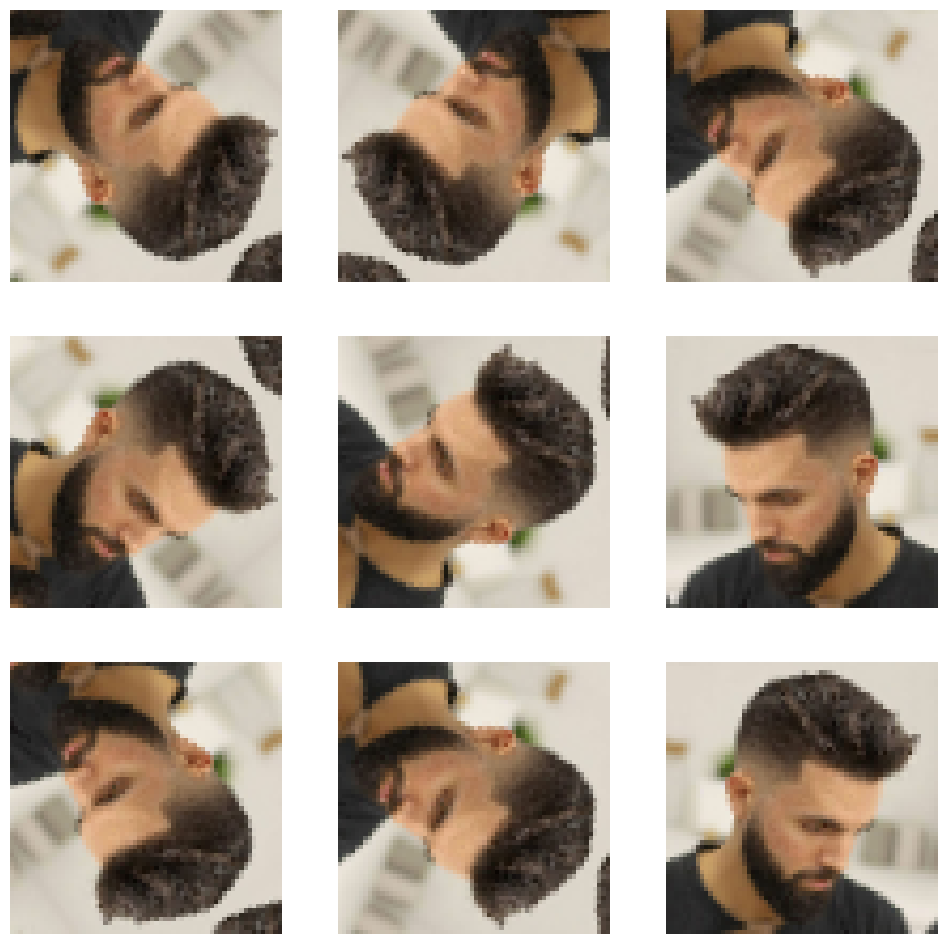

In [159]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(64,
                                  64,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# function to randomly flip image and rotate 
from tensorflow.keras.layers.experimental import preprocessing

def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(preprocessing.RandomFlip('horizontal_and_vertical'))  # Flip img horizontally
    data_augmentation.add(preprocessing.RandomRotation(0.2))        # Rotate randomly
    return data_augmentation



# for illustration, print augmented images of an input image in training data
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [160]:
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [174]:
model = Sequential()
model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
#model.add(layers.Rescaling(1.0 / 255))
model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))


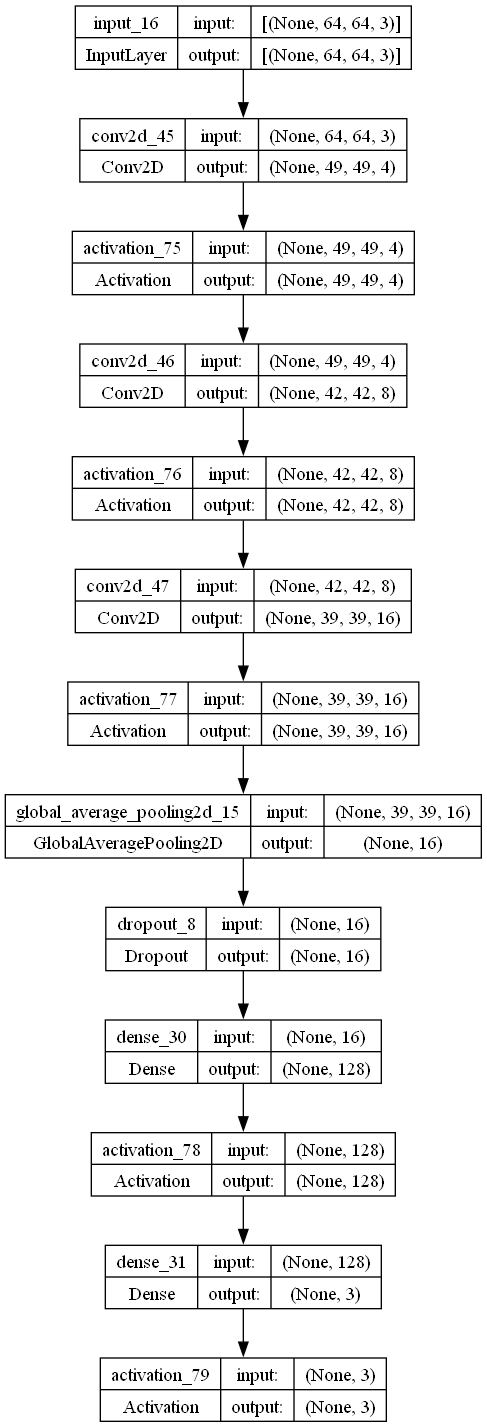

In [175]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [163]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 49, 49, 4)         3076      
                                                                 
 activation_65 (Activation)  (None, 49, 49, 4)         0         
                                                                 
 conv2d_40 (Conv2D)          (None, 42, 42, 8)         2056      
                                                                 
 activation_66 (Activation)  (None, 42, 42, 8)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 39, 39, 16)        2064      
                                                                 
 activation_67 (Activation)  (None, 39, 39, 16)        0         
                                                                 
 global_average_pooling2d_1  (None, 16)              

In [168]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 10
history = model.fit(train_ds_augmented, epochs=epochs, validation_data=val_ds)

Epoch 1/10
25/25 [==============================] - 3s 106ms/step - loss: 1.0986 - accuracy: 0.3465 - val_loss: 1.1001 - val_accuracy: 0.2908
Epoch 2/10
25/25 [==============================] - 2s 99ms/step - loss: 1.0981 - accuracy: 0.3516 - val_loss: 1.1007 - val_accuracy: 0.2908
Epoch 3/10
25/25 [==============================] - 3s 100ms/step - loss: 1.0980 - accuracy: 0.3490 - val_loss: 1.1013 - val_accuracy: 0.2908
Epoch 4/10
25/25 [==============================] - 2s 98ms/step - loss: 1.0977 - accuracy: 0.3503 - val_loss: 1.0989 - val_accuracy: 0.2908
Epoch 5/10
25/25 [==============================] - 2s 99ms/step - loss: 1.1154 - accuracy: 0.3516 - val_loss: 1.1228 - val_accuracy: 0.3112
Epoch 6/10
25/25 [==============================] - 2s 100ms/step - loss: 1.0976 - accuracy: 0.3516 - val_loss: 1.1022 - val_accuracy: 0.2908
Epoch 7/10
25/25 [==============================] - 2s 98ms/step - loss: 1.0974 - accuracy: 0.3516 - val_loss: 1.0945 - val_accuracy: 0.3010
Epoch 8/10

In [169]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavyhair."
% tuple(predictions[0])
)



1/1 [==============================] - 0s 48ms/step
This image is 0.34 percent curly hair, 0.32 percent straight hair, and 0.35 percent wavyhair.


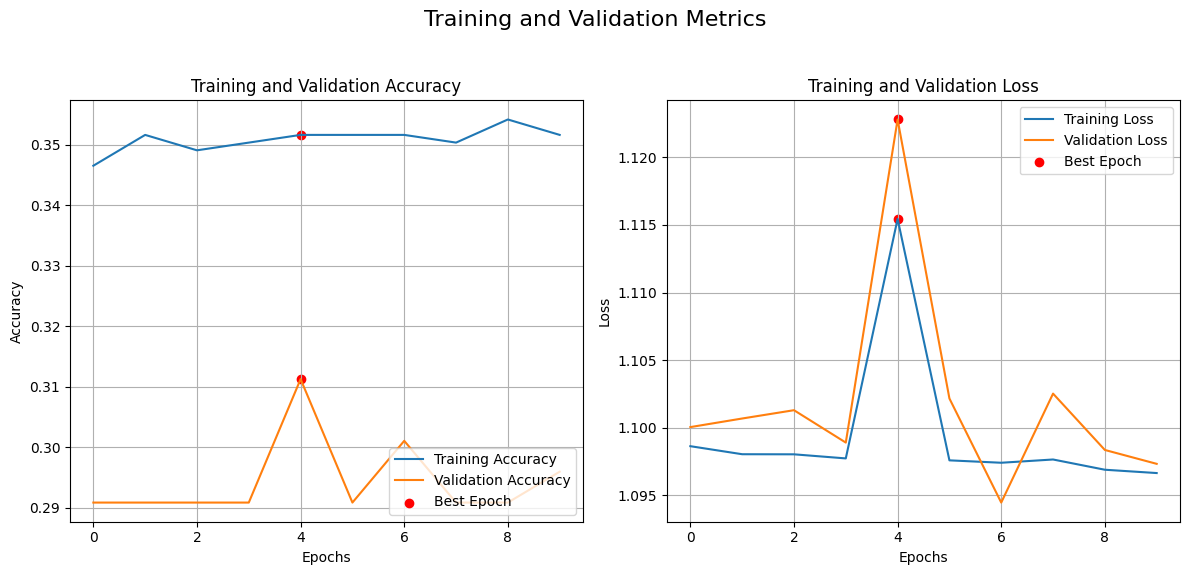

In [170]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

best_epoch = np.argmax(val_acc)

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.scatter(best_epoch, acc[best_epoch], color="red")
plt.scatter(best_epoch, val_acc[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.grid(True)

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.scatter(best_epoch, loss[best_epoch], color="red")
plt.scatter(best_epoch, val_loss[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.grid(True)

plt.suptitle("Training and Validation Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [167]:
print(f"Best Epoch: {best_epoch + 1}")
print(f"Accuracy at Best Epoch: {acc[best_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {val_acc[best_epoch]:.4f}")
print(f"Loss at Best Epoch: {loss[best_epoch]:.4f}")
print(f"Validation Loss at Best Epoch: {val_loss[best_epoch]:.4f}")

Best Epoch: 1
Accuracy at Best Epoch: 0.3070
Validation Accuracy at Best Epoch: 0.3724
Loss at Best Epoch: 2.3999
Validation Loss at Best Epoch: 1.0976
